In [7]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [79]:
import os
from glob import glob
from pathlib import Path
from collections import defaultdict
from pprint import pprint
from random import choice, sample
import cv2
from google.colab.patches import cv2_imshow
import xml.etree.cElementTree as ET

In [80]:
root = '/gdrive/MyDrive/Deep Learning Competition/train'

In [81]:
haze_images = os.path.join(root, 'haze_images')
haze_images_labels = os.path.join(root, 'haze_images_labels')

In [82]:
all_haze_images = glob(haze_images + "/*.jpg")
all_haze_images_box_map = defaultdict(list)
for x in all_haze_images:
    img_without_extention = Path(x)
    haze_image_label = os.path.join(haze_images_labels, f'{img_without_extention.stem}.txt')
    f = open(haze_image_label, "r")
    lines = f.read().strip().split('\n')
    for line in lines:
      line_text = line.strip().split(' ')
      assert len(line_text) == 5, 'Each line must have 5 values' #one identifer and 4 coordinates
      coords = line_text[1:]
      all_haze_images_box_map[x].append(coords)

In [83]:
def visualize_groundtruth_image(img_path):
  image = cv2.imread(img_path)
  assert img_path in all_haze_images_box_map, 'Image path not found in bounding box mapping dictionary'
  coords = all_haze_images_box_map[img_path]
  for coord in coords:
    start_point = (int(coord[0]), int(coord[1]))
    end_point = (int(coord[2]), int(coord[3]))
    color = (255, 0, 0)
    thickness = 2
    cv2.rectangle(image, start_point, end_point, color, thickness)
  return image

In [84]:
def get_hazy_image(img):
  cropped_image = img[:int(img.shape[0]/2)]
  return cropped_image

def get_clean_image(img_path):
  img = cv2.imread(img_path)
  cropped_image = img[int(img.shape[0]/2):]
  return cropped_image

In [85]:
xml_path = os.path.join('/gdrive/MyDrive/Deep Learning Competition/annotate2', 'xml')
Path(xml_path).mkdir(parents=True, exist_ok=True)
def gerenate_basic_structure(filename, im_width, im_height, box_array):
  try:
    annotation = ET.Element('annotation')
    ET.SubElement(annotation, 'filename').text = filename + '.jpg'
    size = ET.SubElement(annotation, 'size')
    ET.SubElement(size, 'width').text = str(im_width)
    ET.SubElement(size, 'height').text = str(im_height)
    ET.SubElement(size, 'depth').text = '3'

    count = 0
    for box in box_array:
      objectBox = ET.SubElement(annotation, 'object')
      ET.SubElement(objectBox, 'name').text = 'vehicle'
      ET.SubElement(objectBox, 'pose').text = 'Unspecified'
      ET.SubElement(objectBox, 'truncated').text = '0'
      ET.SubElement(objectBox, 'difficult').text = '0'
      bndBox = ET.SubElement(objectBox, 'bndbox')
      ET.SubElement(bndBox, 'xmin').text = str(box['xmin'])
      ET.SubElement(bndBox, 'ymin').text = str(box['ymin'])
      ET.SubElement(bndBox, 'xmax').text = str(box['xmax'])
      ET.SubElement(bndBox, 'ymax').text = str(box['ymax'])
      count += 1
    arquivo = ET.ElementTree(annotation)
    arquivo.write(xml_path+ "/" + filename + '.xml')
  except Exception as e:
    print('Error to generate the XML for image {}'.format(filename))
    print(e)

In [86]:
im_height, im_width, channels = cv2.imread(haze_images + "/000.jpg").shape
im_height, im_width, channels

(1500, 1845, 3)

In [87]:
len(all_haze_images_box_map)

177

In [88]:
hazed_ground_truth = os.path.join('/gdrive/MyDrive/Deep Learning Competition/annotate2', 'hazed_ground_truth')
Path(hazed_ground_truth).mkdir(parents=True, exist_ok=True)

all_haze_images = glob(haze_images + "/*.jpg")
for image_path in all_haze_images:
  bounding_boxes = all_haze_images_box_map[image_path]
  ground_truth = visualize_groundtruth_image(image_path)
  hazy_ground_truth_image = get_hazy_image(ground_truth)
  prefix = str(Path(image_path).stem)
  image_path = prefix + ".jpg"
  hazy_ground_truth_file = os.path.join(hazed_ground_truth, f'{image_path}')
  cv2.imwrite(hazy_ground_truth_file, hazy_ground_truth_image) 
  

  box_array = []
  for box in bounding_boxes:
    box_dict = {}
    xmin = box[0]
    ymin = box[1]
    xmax = box[2]
    ymax = box[3]
    box_dict['xmin'] = xmin
    box_dict['ymin'] = ymin
    box_dict['ymax'] = ymax
    box_dict['xmax'] = xmax
    box_array.append(box_dict)
  gerenate_basic_structure(prefix, 1845, 750, box_array)
  

In [1]:
import torch
!pip install detecto

In [8]:
from detecto import core, utils, visualize
from detecto.visualize import show_labeled_image, plot_prediction_grid
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

In [9]:
custom_transforms = transforms.Compose([
transforms.ToPILImage(),
transforms.Resize(900),
transforms.RandomHorizontalFlip(0.5),
transforms.ColorJitter(saturation=0.2),
transforms.ToTensor(),
utils.normalize_transform(),
])

In [36]:
Train_dataset=core.Dataset('/gdrive/MyDrive/Deep Learning Competition/Dataset/Train/',transform=custom_transforms)#L1
Test_dataset = core.Dataset('/gdrive/MyDrive/Deep Learning Competition/Dataset/Test/')#L2
# loader=core.DataLoader(Train_dataset, batch_size=2, shuffle=True)#L3
# model = core.Model([‘Wheel’, ‘Head Light’])#L4

In [37]:
Train_dataset
len(Test_dataset)

17

In [58]:
loader=core.DataLoader(Train_dataset, batch_size=2, shuffle=True)#L3

In [59]:
model = core.Model(['vehicle'])#L4

In [60]:
losses = model.fit(loader, val_dataset=Test_dataset, epochs=10, lr_step_size=5, learning_rate=0.001, verbose=True)#L5

Epoch 1 of 10
Begin iterating over training dataset


100%|██████████| 80/80 [01:38<00:00,  1.24s/it]


Begin iterating over validation dataset


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Loss: 12.8921318860615
Epoch 2 of 10
Begin iterating over training dataset


100%|██████████| 80/80 [01:39<00:00,  1.24s/it]


Begin iterating over validation dataset


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Loss: 13.604680312906995
Epoch 3 of 10
Begin iterating over training dataset


100%|██████████| 80/80 [01:39<00:00,  1.24s/it]


Begin iterating over validation dataset


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Loss: 12.759218636681052
Epoch 4 of 10
Begin iterating over training dataset


100%|██████████| 80/80 [01:38<00:00,  1.24s/it]


Begin iterating over validation dataset


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Loss: 12.248829927514581
Epoch 5 of 10
Begin iterating over training dataset


100%|██████████| 80/80 [01:38<00:00,  1.23s/it]


Begin iterating over validation dataset


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Loss: 12.23257628083229
Epoch 6 of 10
Begin iterating over training dataset


100%|██████████| 80/80 [01:38<00:00,  1.24s/it]


Begin iterating over validation dataset


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Loss: 11.367964376421536
Epoch 7 of 10
Begin iterating over training dataset


100%|██████████| 80/80 [01:38<00:00,  1.24s/it]


Begin iterating over validation dataset


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Loss: 11.916724634521147
Epoch 8 of 10
Begin iterating over training dataset


100%|██████████| 80/80 [01:38<00:00,  1.23s/it]


Begin iterating over validation dataset


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Loss: 12.250917671357884
Epoch 9 of 10
Begin iterating over training dataset


100%|██████████| 80/80 [01:38<00:00,  1.23s/it]


Begin iterating over validation dataset


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Loss: 12.235346299760481
Epoch 10 of 10
Begin iterating over training dataset


100%|██████████| 80/80 [01:38<00:00,  1.23s/it]


Begin iterating over validation dataset


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]

Loss: 11.628411392955218


In [29]:
model.save('/gdrive/MyDrive/Deep Learning Competition/trained_model/model_weights.pth')
model = core.Model.load('/gdrive/MyDrive/Deep Learning Competition/trained_model/model_weights.pth', ['vehicle'])

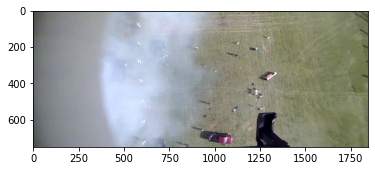

In [77]:
image = utils.read_image('/gdrive/MyDrive/2nd Semester/Coursework/Deep Learning/Competition/Submission Feb 20th Onwards/UG2+_Track1/train/dry-run-1/new_068.jpg') 
#image = utils.read_image('/gdrive/MyDrive/Deep Learning Competition/Dataset/Train/160.jpg')
predictions = model.predict(image)
labels, boxes, scores = predictions
show_labeled_image(image, boxes, labels)

In [78]:
scores

tensor([])

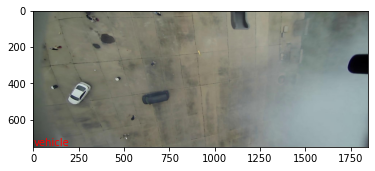

In [51]:
thresh=0.0
filtered_indices=np.where(scores>thresh)
filtered_scores=scores[filtered_indices]
filtered_boxes=boxes[filtered_indices]
num_list = filtered_indices[0].tolist()
filtered_labels = [labels[i] for i in num_list]
show_labeled_image(image, filtered_boxes, filtered_labels)